# Datasets comparison between CAMS and GOME-2 (L2)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3
import subprocess # Important for GOME-2
import bs4 # Important for GOME-2 L2
import h5py # Important for GOME-2 L2

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_gome.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (NO2, O3 or HCHO)
component_nom = 'O3'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'gome'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2021-10-01'
end_date = '2021-10-02'

# Define extent
lon_min = -180
lon_max = 180
lat_min = -90
lat_max = 0

# Define resolution (Minimum: 0.25x0.25)
lat_res = 1
lon_res = 1

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: ('2021-10-01', '2021-10-02')
SEARCH BOUNDING BOX
Latitudes: from -90 to 0
Longitudes: from -180 to 180


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single', 
                                               CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [8]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

2021-12-11 11:37:01,706 WARNING Ignoring index file '/home/alba/adc-toolbox/data/cams/O3/O3-hourly-tc-2021-10-01-2021-10-02.grib.923a8.idx' incompatible with GRIB file


<xarray.Dataset>
Dimensions:     (latitude: 226, longitude: 900, step: 8, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-10-01 2021-10-02
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 ... -0.8 -0.4 -2.033e-13
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-11T11:37 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


## 3. Sensor data

### Download and read data as xarray

In [11]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

RESULTS
For 2021-10-01:
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211001012047_051_METOPA_77575_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211001030211_051_METOPA_77576_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211001044335_051_METOPA_77577_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211001062453_051_METOPA_77578_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211001080617_051_METOPA_77579_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211001094741_051_METOPA_77580_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211001113123_048_METOPA_77581_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211001131023_051_METOPA_77582_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211001145147_051_METOPA_77583_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211001163311_051_METOPA_

In [12]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, 
                              dates, satellites, lat_res, lon_res)
sensor_ds

/tmp/ipykernel_861497/3974393958.py:97: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts
/tmp/ipykernel_861497/3974393958.py:97: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.Dataset>
Dimensions:        (latitude: 180, longitude: 360, time: 2)
Coordinates:
  * latitude       (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude      (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * time           (time) datetime64[ns] 2021-10-01 2021-10-02
Data variables:
    sensor_column  (time, latitude, longitude) float64 nan nan nan ... nan nan
    delta_time     (time, latitude, longitude) datetime64[ns] NaT NaT ... NaT

## 4. Match data

In [13]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, apply_kernels)
match_df

FOR DATE: 2021-10-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR DATE: 2021-10-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.


,latitude,longitude,sensor_column,delta_time,time,step_index,model_column
0,-89.5,-179.5,NaN,2021-10-01 12:00:00,2021-10-01,4,112.309662
1,-89.5,-178.5,NaN,2021-10-01 12:00:00,2021-10-01,4,112.314056
2,-89.5,-177.5,NaN,2021-10-01 12:00:00,2021-10-01,4,112.316727
3,-89.5,-176.5,NaN,2021-10-01 12:00:00,2021-10-01,4,112.320229
4,-89.5,-175.5,NaN,2021-10-01 12:00:00,2021-10-01,4,112.323250
...,...,...,...,...,...,...,...
32395,-0.5,175.5,263.054639,2021-10-02 20:53:04,2021-10-02,7,258.938477
32396,-0.5,176.5,259.397924,2021-10-02 20:53:04,2021-10-02,7,258.305573
32397,-0.5,177.5,261.940043,2021-10-02 20:53:04,2021-10-02,7,256.247070
32398,-0.5,178.5,260.524336,2021-10-02 20:53:04,2021-10-02,7,255.410660


## 5. Merge data and calculate difference

In [14]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column  difference  \
latitude longitude time                                                  
-89.5    -179.5    2021-10-01    112.309662            NaN         NaN   
         -178.5    2021-10-01    112.314056            NaN         NaN   
         -177.5    2021-10-01    112.316727            NaN         NaN   
         -176.5    2021-10-01    112.320229            NaN         NaN   
         -175.5    2021-10-01    112.323250            NaN         NaN   
...                                     ...            ...         ...   
-0.5      175.5    2021-10-02    258.938477     263.054639    4.116162   
          176.5    2021-10-02    258.305573     259.397924    1.092351   
          177.5    2021-10-02    256.247070     261.940043    5.692973   
          178.5    2021-10-02    255.410660     260.524336    5.113676   
          179.5    2021-10-02    255.766327            NaN         NaN   

                               relative_difference  
latitude longitude time                             
-89.5    -179.5    2021-10-01                  NaN  
         -178.5    2021-10-01                  NaN  
         -177.5    2021-10-01                  NaN  
         -176.5    2021-10-01                  NaN  
         -175.5    2021-10-01                  NaN  
...                                            ...  
-0.5      175.5    2021-10-02            -0.015648  
          176.5    2021-10-02            -0.004211  
          177.5    2021-10-02            -0.021734  
          178.5    2021-10-02            -0.019628  
          179.5    2021-10-02                  NaN  

[64800 rows x 4 columns]

In [15]:
descr_statistics_table = merge_df.describe()
descr_statistics_table

,model_column,sensor_column,difference,relative_difference
count,64800.000000,50143.000000,50143.000000,50143.000000
mean,260.201635,276.795106,4.037572,-0.016050
std,81.253822,74.406245,7.529418,0.029232
min,100.125694,103.500816,-58.596802,-0.239863
25%,189.739883,253.365848,-0.466957,-0.030476
50%,282.598831,291.167694,3.210938,-0.011716
75%,317.441605,326.817140,7.638998,0.001688
max,452.894867,473.980003,104.384460,0.220708


## 6. Show comparison plots

### Select plot dates

In [16]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-10' '2021-10']


### Select plot extent

In [17]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-180, -90), (180, 0))


### Compare CAMS and GOME-2 total columns

In [18]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'animated'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection=ccrs.Orthographic(180, -90)
color_scale = 'jet'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.10, 
                          model_type, sensor_type, range_type, distribution_type, projection, 
                          color_scale, vmin_manual, vmax_manual)

2021-12-11 12:19:08,907 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


2021-12-11 12:19:11,078 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-12-11 12:19:11,080 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1800x720 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y animation.gif


## 7. Retrieve nearest values to specific latitude and longitude

model_column  \
lat_search lon_search latitude longitude time                       
-80        30         -80.5    29.5      2021-10-01    125.656212   
                                         2021-10-02    117.142616   
-70        30         -70.5    29.5      2021-10-01    156.739166   
                                         2021-10-02    147.393875   
-50        30         -50.5    29.5      2021-10-01    374.636169   
                                         2021-10-02    342.629883   

                                                     sensor_column  \
lat_search lon_search latitude longitude time                        
-80        30         -80.5    29.5      2021-10-01     131.258118   
                                         2021-10-02     126.179459   
-70        30         -70.5    29.5      2021-10-01     162.421274   
                                         2021-10-02     147.800461   
-50        30         -50.5    29.5      2021-10-01     383.134018   
                                         2021-10-02     350.618347   

                                                     difference  \
lat_search lon_search latitude longitude time                     
-80        30         -80.5    29.5      2021-10-01    5.601906   
                                         2021-10-02    9.036842   
-70        30         -70.5    29.5      2021-10-01    5.682108   
                                         2021-10-02    0.406586   
-50        30         -50.5    29.5      2021-10-01    8.497849   
                                         2021-10-02    7.988464   

                                                     relative_difference  
lat_search lon_search latitude longitude time                             
-80        30         -80.5    29.5      2021-10-01            -0.042679  
                                         2021-10-02            -0.071619  
-70        30         -70.5    29.5      2021-10-01            -0.034984  
                                         2021-10-02            -0.002751  
-50        30         -50.5    29.5      2021-10-01            -0.022180  
                                         2021-10-02            -0.022784

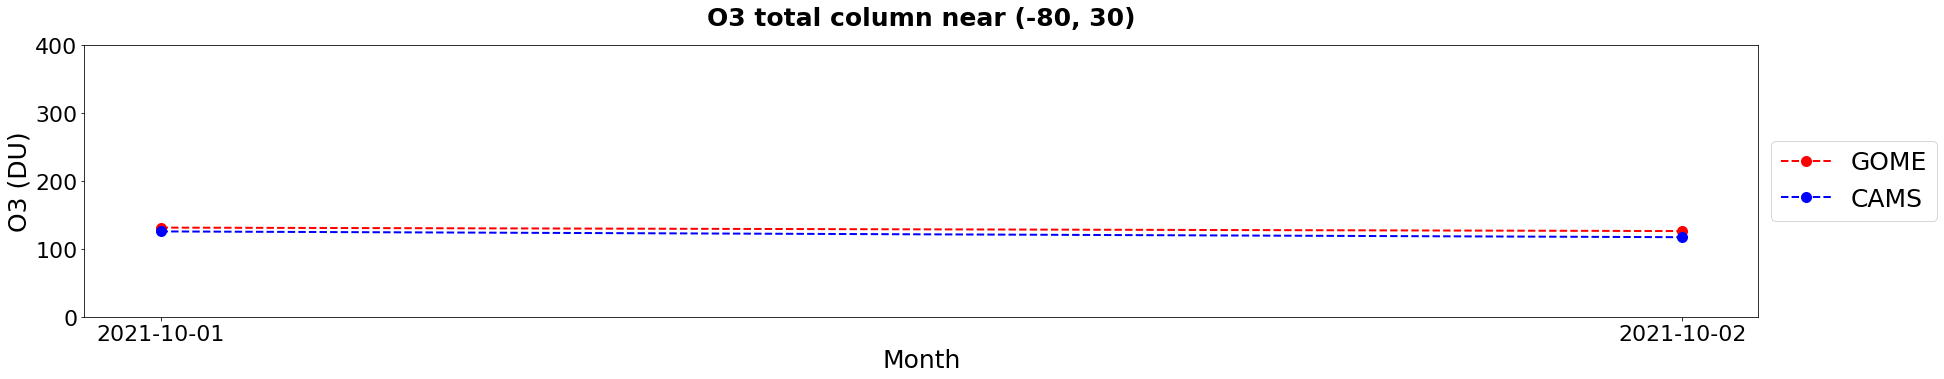

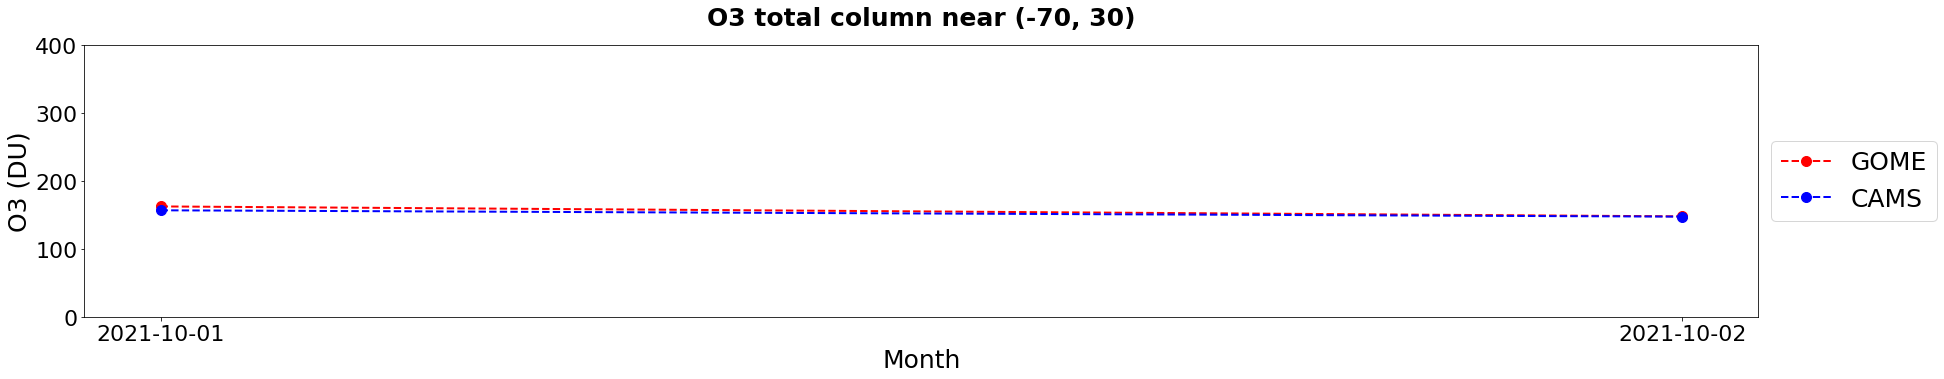

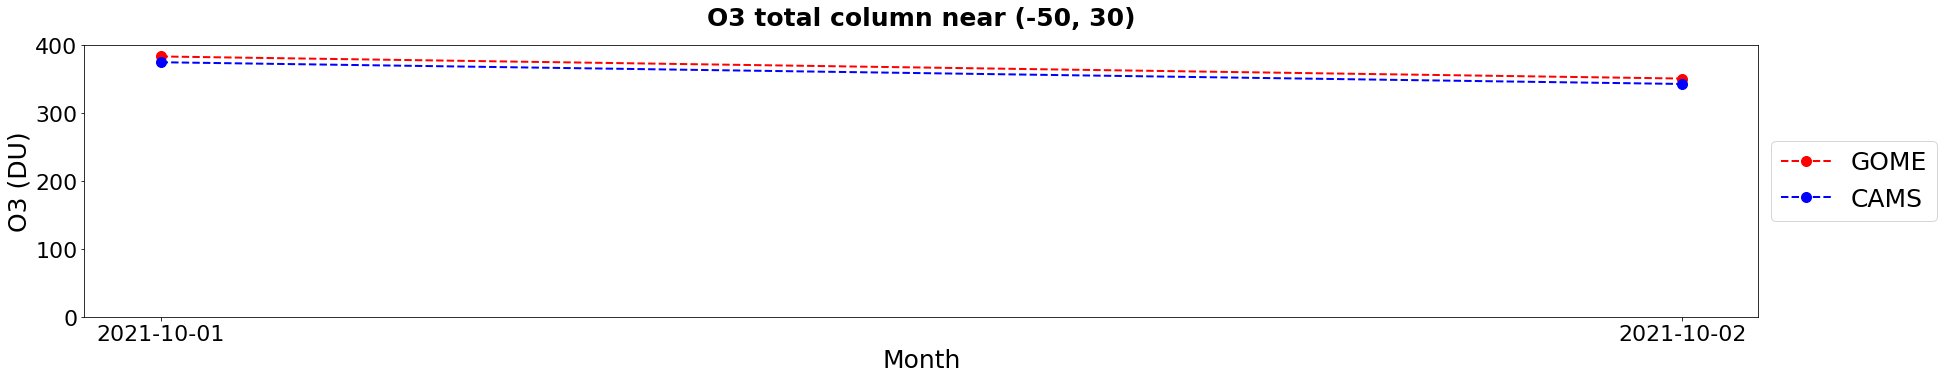

In [20]:
coords_search_list = (-80, 30,
                      -70, 30,
                      -50, 30)
ymin = 0
ymax = 400
xticks = plot_dates
retrieval_table_all =  retrieve_coords(merge_df.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units, ymin, ymax, xticks)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: O3_model = O3_sensor * 1.00 + (-3.45E+00)
Coefficient of determination (R2): 0.99


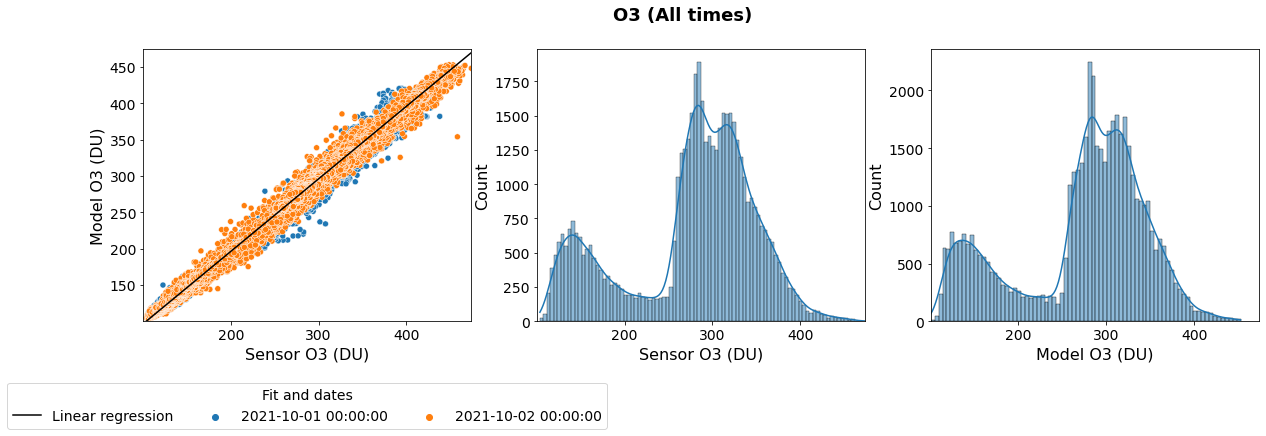

In [21]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [22]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2021-10-01T00:00:00.000000000, 2021-10-02T00:...","((-180, -90), (180, 0))",0.989825,0.997879,-3.450549


## 9. Scatter plots by season

Fit equation: O3_model = O3_sensor * 1.00 + (-3.45E+00)
Coefficient of determination (R2): 0.99


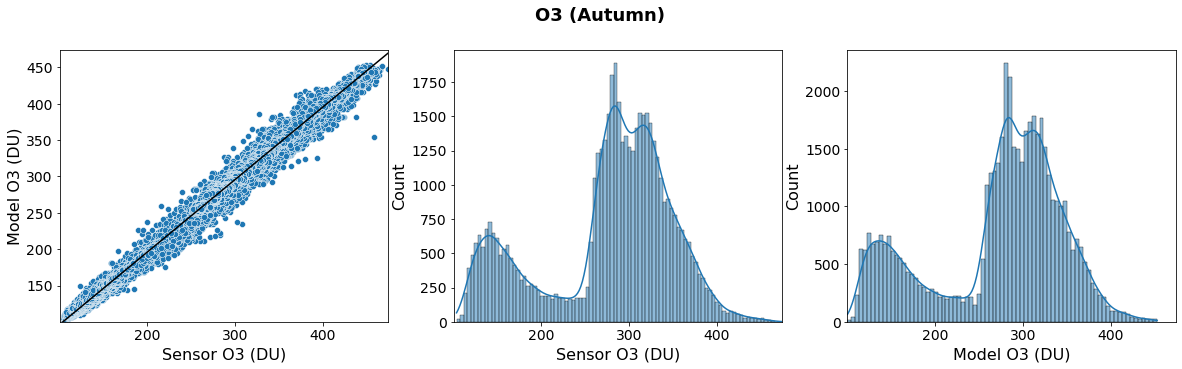

In [23]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [24]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Autumn,"((-180, -90), (180, 0))",0.989825,0.997879,-3.450549


## 10. Scatter plots by country (Google API required!)

In [25]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['Argentina', 'Chile', 'Australia']

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['Argentina', 'Chile', 'Australia']\n\nlim_min = None\nlim_max = None\n\nsummary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [26]:
#summary